In [1]:
import sys
import os
rise_sfl_path = "/content/RISE-SFL/RISE-SFL"  # Replace with the actual path to your RISE-SFL folder
sys.path.append(rise_sfl_path)
from utils.utils import *
# From masker/generation.py
from masker.generation import SFL

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from PIL import Image
import json
from torch.nn.functional import softmax, conv2d
import os
import requests
import zipfile

In [2]:
cudnn.benchmark = True
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False


c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from masker.batch import SFL_batch

input_size = (224,224)
sfl_batch = SFL_batch(model, input_size)
image_folder = r'C:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\RISE-SFL\data_demo'
N = 10
s = 8
p1 = 0.2
masks, sampled_tensors = sfl_batch.generate_batch_images(image_folder, N, s, p1)

Processing images:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\eagua\OneDrive\Documents\GitHub\6CCS3COV-7CCSMCVI-Computer-Vision\RISE-SFL\RISE-SFL\masker\generation.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cell_size = torch.ceil(torch.tensor(self.input_size).float() / s)
Processing images: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


In [4]:
def generate_pass_fail_list(N):
    return ["Pass" if i % 2 == 0 else "Fail" for i in range(N)]

pass_fail_list = generate_pass_fail_list(N)

from visuals.plots import SFLVisualizer

In [5]:
#If we want to observe any of the images that are being explained, we just need to 
visualizer = SFLVisualizer()
visualizer.interactive_mutant_visualization(sampled_tensors[2], pass_fail_list)


interactive(children=(IntSlider(value=0, description='Mutant Index:', max=9), Output()), _dom_classes=('widget…

In [6]:
from sfl_techniques.sfl import RelevanceScore
#A dictionary will be return for the image to be explained

# For each image, after returning the dictionary, we need to use causal metrics to calculate which one is more efficient
relevance_score_calculator = RelevanceScore(device='cuda')

pixel_datasets = []

for i in range(3):
    pixel_dataset = relevance_score_calculator.run(sampled_tensors[i], masks[i], N)
    pixel_datasets.append(pixel_dataset)

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


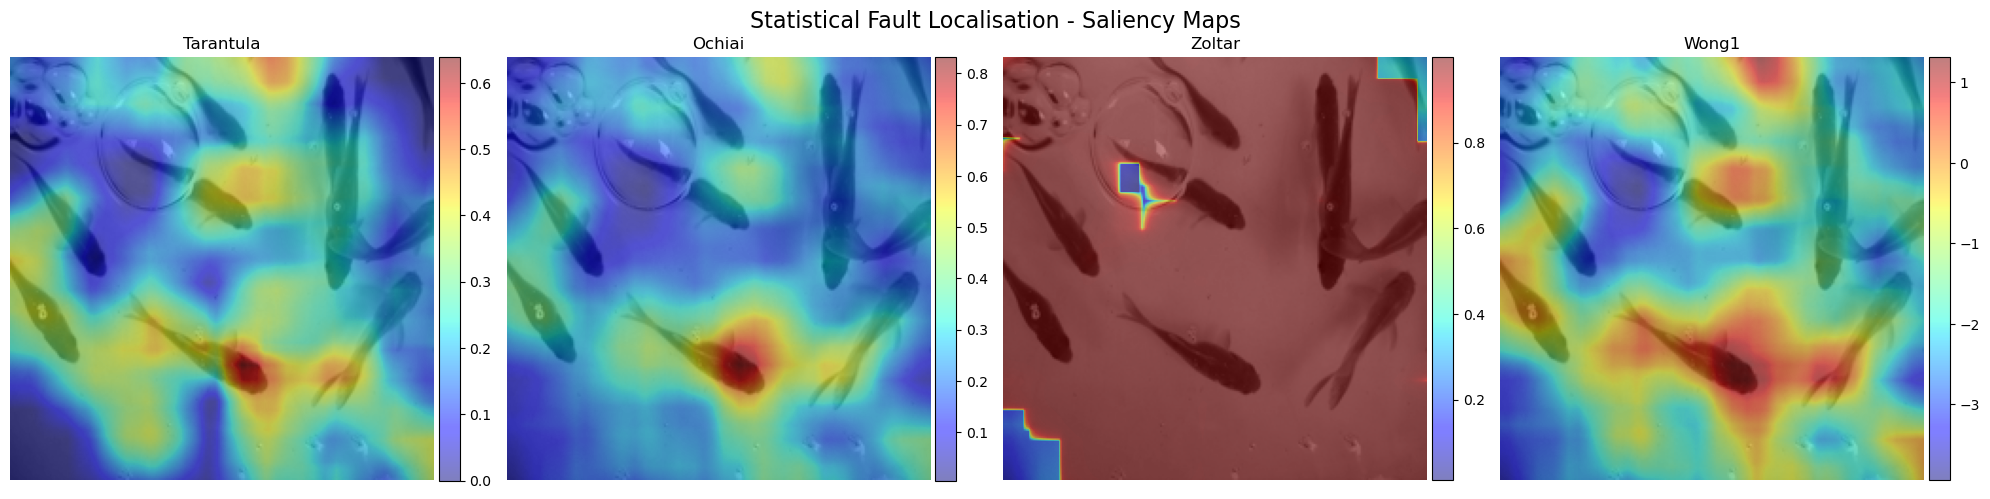

In [21]:
from visuals.saliency_maps.saliency import SaliencyMapVisualizer

# List all files in the directory
all_files = os.listdir(image_folder)

# Filter for .jpg and .png files
image_files = [file for file in all_files if file.lower().endswith(('.jpg', '.png'))]

# Check if there are any image files in the directory
if not image_files:
    print("No .jpg or .png files found in the specified directory.")
else:
    # Retrieve the first image file
    image_path = os.path.join(image_folder, image_files[2])

saliency_map = SaliencyMapVisualizer(image_path)
saliency_map.visualize_pixel_scores(pixel_datasets[2],ins='')
